In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)
from deepxde.callbacks import ModelCheckpoint
import tensorflow as tf

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Parâmetros

In [2]:
# Geometria e tempo
WIDTH = LENGTH = 10
T_END = 2 * np.pi

# Taxa de difusão
k = 10**(-8)

In [19]:
#Pontos de amostragem
SAMPLE_POINTS = 3000

#Rede Neural
ARCHITECTURE = (
    [3] + [120] * 1 + [1]
)
ACTIVATION = "sin"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 0.049999999999999996
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 16

# Pesos dos componentes da função de perda (!!!)
LOSS_WEIGHTS = [
    100, #pde
    0.1,
    0.1,
    0.1,
    0.1, #up
    50, #ic
]

## Geometria

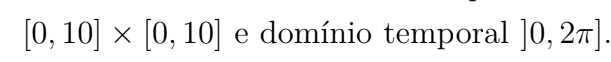

In [4]:
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])
timedomain = dde.geometry.TimeDomain(0, T_END)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Equação Diferencial

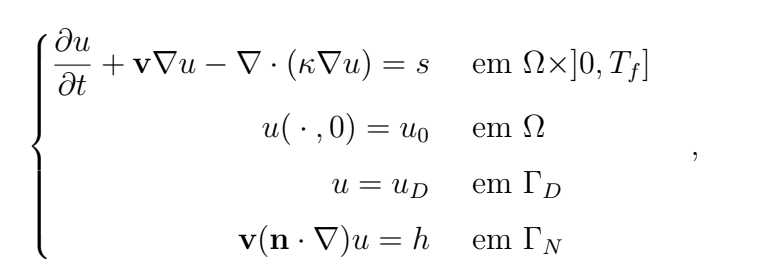

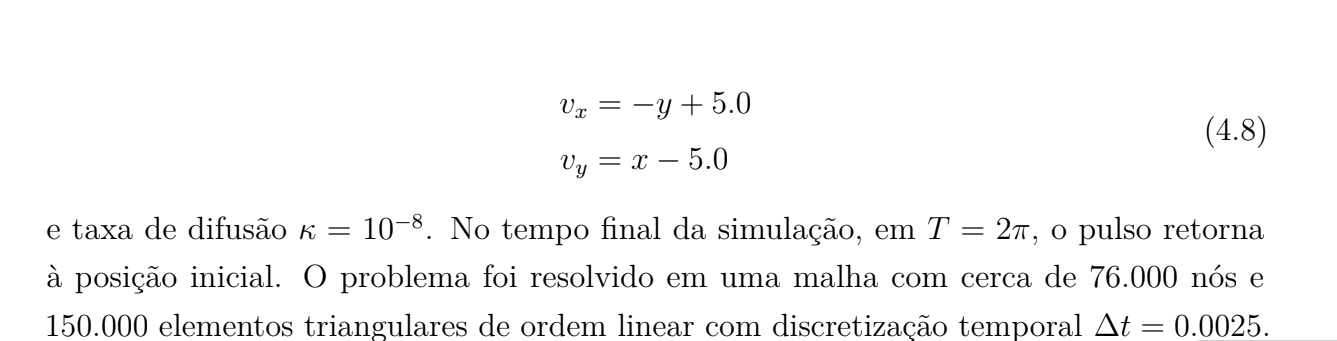

In [5]:
def pde(X, U):
    dU_x = dde.grad.jacobian(U, X, j=0)
    dU_y = dde.grad.jacobian(U, X, j=1)
    dU_t = dde.grad.jacobian(U, X, j=2)

    dU_xx = dde.grad.hessian(U, X, i=0, j=0)
    dU_yy = dde.grad.hessian(U, X, i=1, j=1)

    return dU_t + (5 - X[:, 1:2]) * dU_x + (X[:, 0:1] - 5) * dU_y - k * (dU_xx + dU_yy)

## Condições da EDO

### Condição Inicial

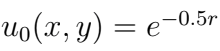

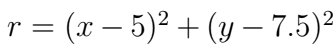

In [6]:
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

#Vetor para descrever o retorno da função com base em e^(-0.5 * r)
def func(x):
    r = np.power(x[:, 0:1] - 5, 2) + np.power(x[:, 1:2] - 7.5, 2)
    return np.exp(-0.5 * r)

### Condições de Dirichlet

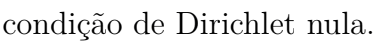

In [7]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

#Vetor de zeros para descrever o retorno da função
def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

In [8]:
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, func_zero, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)

ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

## Dados que serão usados na PDE

In [9]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_low, bc_up, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
    num_test=int(SAMPLE_POINTS / 2),
)

## Rede Neural

In [21]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)

model = dde.Model(data, net)
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)

Compiling model...
'compile' took 0.000266 s



In [ ]:
# checker = dde.callbacks.ModelCheckpoint(
#       f"pinns/gaussian_pulse/figure_3/model.ckpt", save_better_only=True, period=1000, verbose=1
#   )

# losshistory, trainstate = model.train(
#     iterations=ITERATIONS,
#     batch_size=BATCH_SIZE,
#     callbacks=[checker],
# )

In [ ]:
# dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
# plt.show()
# plt.savefig("loss_history_plot_Pulso")
# plt.close()

--------

In [ ]:
# dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
# plt.show()
# plt.savefig("loss_history_gaussian_pulse")
# plt.close()

## Predição e Animação

In [ ]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

nelx = 128  # Número de elementos em x
nely = 128  # Número de elementos em y
timesteps = 401

x = np.linspace(0, WIDTH, nelx + 1)
y = np.linspace(0, LENGTH, nely + 1)
t = np.linspace(0, T_END, timesteps)

# Dados pra serem usados na predição
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [ ]:
# Predição da solução
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)

In [ ]:
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Cria a imagem inicial com a barra de cores
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, WIDTH, 0, LENGTH],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Atualiza os frames
    def updatefig(k):
        # Atualiza a imagem em si
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Atualiza também as cores limitantes

        cb.update_normal(im)

        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


animate_solution(
    predicted_solution,
    f"gaussian_pulse_rotation.mp4",
    "Gaussian Pulse Rotation",
    "u(x,y,t)",
    t,
)

In [11]:
import pandas as pd

sol_malha_128 = pd.read_csv("pinns/gaussian_pulse/pulso_sol_libmesh.csv")

sol_malha_128.head()

,u,ids,object_id,vtkValidPointMask,arc_length,Points:0,Points:1,Points:2
0,1.563600e-26,65,0,1,0.00,5,0.00,0
1,1.195600e-13,65,0,1,0.01,5,0.01,0
2,2.391200e-13,65,0,1,0.02,5,0.02,0
3,3.586900e-13,65,0,1,0.03,5,0.03,0
4,4.782500e-13,65,0,1,0.04,5,0.04,0


In [12]:
!pip install seaborn

In [13]:
num_values = 1000

x = np.ones((num_values, 1)) * 5 # x = 5
y = np.linspace(0, 10, num_values).reshape(-1, 1) # y variável
t = np.ones((num_values, 1)) * (2 * np.pi) # t = 2 * pi

In [14]:
input_data = np.hstack((x, y, t))

In [16]:
model.restore(f"pinns/gaussian_pulse/outputs/model/model_16.ckpt-5000.pt")

In [17]:
predicted_solution_best = np.empty((num_values, 1))
for i in range(num_values):
    predicted_solution_best[i] = model.predict(input_data[i].reshape(1, -1))

In [22]:
model.restore("pinns/gaussian_pulse/outputs/model/model_24.ckpt-7000.pt")

In [24]:
predicted_solution_worst = np.empty((num_values, 1))
for i in range(num_values):
    predicted_solution_worst[i] = model.predict(input_data[i].reshape(1, -1))

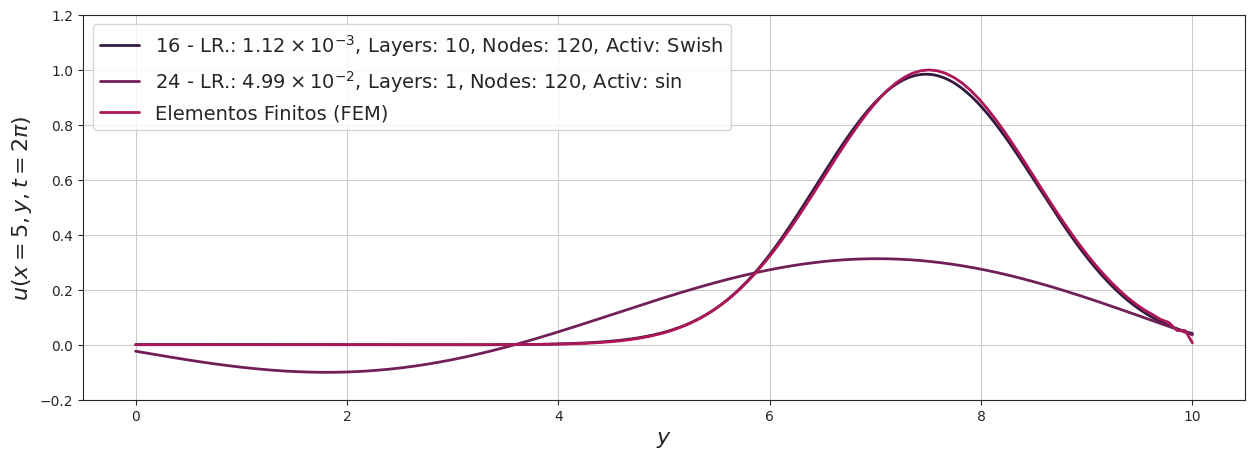

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir a paleta de cores e o estilo
palette = sns.color_palette("rocket")
sns.set_palette(palette)
sns.set_style("ticks", {'axes.grid': True})

# Criar a figura e o eixo
fig, ax1 = plt.subplots(figsize=(15, 5))

# Definir os rótulos dos eixos com LaTeX
ax1.set_xlabel(r'$y$', fontsize=16)
ax1.set_ylabel(r'$u(x = 5, y, t = 2\pi)$', fontsize=16)

# Plot do melhor modelo
label = r"$16$ - LR.: $1.12 \times 10^{-3}$, Layers: 10, Nodes: 120, Activ: Swish"
sns.lineplot(x=y.flatten(), y=predicted_solution_best.reshape(y.flatten().shape), linewidth=2, label=label, ax=ax1, color=sns.color_palette("rocket")[0])

label = r"$24$ - LR.: $4.99 \times 10^{-2}$, Layers: 1, Nodes: 120, Activ: sin"
sns.lineplot(x=y.flatten(), y=predicted_solution_worst.reshape(y.flatten().shape), linewidth=2, label=label, ax=ax1, color=sns.color_palette("rocket")[1])

label = "Elementos Finitos (FEM)"
sns.lineplot(x=y.flatten(), y=sol_malha_128.iloc[:-1]["u"], linewidth=2, label=label, ax=ax1, color=sns.color_palette("rocket")[2])

# Aumentar o tamanho da legenda
ax1.legend(fontsize=14)  # Ajuste o valor de fontsize conforme necessário
ax1.set_ylim(ymin=-0.2, ymax=1.2)


# Mostrar e salvar a figura
plt.show()
fig.savefig('pinns/gaussian_pulse/plots/com_escala.png', bbox_inches='tight')
plt.close(fig)

In [ ]:
y_true = np.array(sol_malha_128.iloc[:-1]["u"])
y_pred = np.array(predicted_solution).reshape(y_true.shape)

In [ ]:
mse = np.mean((y_true - y_pred) ** 2)

print("MSE:", mse)

In [ ]:
np.std((y_true - y_pred))

In [ ]:
l2_norm = np.linalg.norm(y_true - y_pred)

print("L2:", l2_norm)